# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.classification import LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import time
from datetime import datetime
from functools import reduce
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel



In [2]:

spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Churn Analysis") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_event_data = "mini_sparkify_event_data.json"
df_sparkify = spark.read.json(sparkify_event_data)
df_sparkify.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df_sparkify.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df_sparkify.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [6]:
df_sparkify.toPandas().isnull().sum()

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

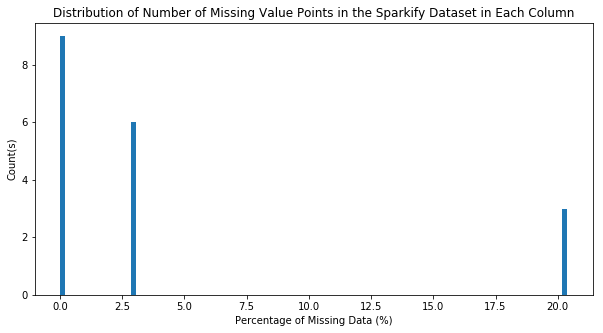

In [7]:
null_number = df_sparkify.toPandas().isnull().sum()

plt.figure(figsize=(10, 5))
plt.title('Distribution of Number of Missing Value Points in the Sparkify Dataset in Each Column')
plt.hist(null_number / df_sparkify.count() * 100, bins=100)
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Count(s)')
plt.show()

In [8]:
# Investigate patterns in the amount of missing data in each column
data_under_2 = (null_number / df_sparkify.count() * 100) <= 2
data_over_2 = (null_number / df_sparkify.count() * 100) > 2
attri_over_2 = null_number.loc[(null_number / df_sparkify.count() * 100) > 2]
print("Attributes with equal to or under 2% of missing data: {}".format(data_under_2.sum()))
print("Attributes with over 2% of missing data: {}".format(data_over_2.sum()))
print("Attributes with missing data that exceeds 2%: \n{}".format(attri_over_2 / df_sparkify.count() * 100))

Attributes with equal to or under 2% of missing data: 9
Attributes with over 2% of missing data: 9
Attributes with missing data that exceeds 2%: 
artist          20.381152
firstName        2.913089
gender           2.913089
lastName         2.913089
length          20.381152
location         2.913089
registration     2.913089
song            20.381152
userAgent        2.913089
dtype: float64


In [9]:
# Remove the outlier columns from the dataset
df_sparkify = df_sparkify.drop(*['artist', 'firstname', 'lastname', 'length', 'registration', 'userAgent'])
df_sparkify.show()


+---------+------+-------------+-----+--------------------+------+---------------+---------+--------------------+------+-------------+------+
|     auth|gender|itemInSession|level|            location|method|           page|sessionId|                song|status|           ts|userId|
+---------+------+-------------+-----+--------------------+------+---------------+---------+--------------------+------+-------------+------+
|Logged In|     M|           50| paid|     Bakersfield, CA|   PUT|       NextSong|       29|           Rockpools|   200|1538352117000|    30|
|Logged In|     M|           79| free|Boston-Cambridge-...|   PUT|       NextSong|        8|              Canada|   200|1538352180000|     9|
|Logged In|     M|           51| paid|     Bakersfield, CA|   PUT|       NextSong|       29|   Time For Miracles|   200|1538352394000|    30|
|Logged In|     M|           80| free|Boston-Cambridge-...|   PUT|       NextSong|        8|Knocking On Forbi...|   200|1538352416000|     9|
|Logge

In [10]:
df_sparkify.toPandas().isnull().sum()

auth                 0
gender            8346
itemInSession        0
level                0
location          8346
method               0
page                 0
sessionId            0
song             58392
status               0
ts                   0
userId               0
dtype: int64

artist', 'firstname', ', 'lastname', 'length', ', 'registration',  'userAgent'])

In [11]:
print(df_sparkify.count(), len(df_sparkify.columns))

286500 12


In [12]:
df_sparkify.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
df_sparkify = df_sparkify.filter((df_sparkify.userId!="") | (df_sparkify.sessionId!=""))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
churn_users = df_sparkify.filter(df_sparkify.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = churn_users.toPandas()['userId'].values.tolist()
df_sparkify = df_sparkify.withColumn('churn', df_sparkify.userId.isin(churn_users_list))
df_sparkify = df_sparkify.withColumn('region', F.split(df_sparkify.location, ', ')[1])

In [15]:
df_sparkify.select('region').dropDuplicates().count()

58

In [16]:
set_time = F.udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_sparkify = df_sparkify.withColumn("time", F.to_timestamp(set_time(df_sparkify.ts), 'yyyy-MM-dd HH:mm:ss'))

In [17]:

df_sparkify_agg = df_sparkify.groupBy('userId').agg(F.min('gender').alias('gender'),
                                                   F.min('region').alias('region'),
                                                   F.min('ts').alias('firstSession'), 
                                                   F.max('ts').alias('lastSession'),
                                                   F.count('song').alias('songsListened'),
                                                   F.count('sessionId').alias('totalSessions'),
                                                   F.min('churn').alias('churn')).sort('userId')

df_sparkify_agg = df_sparkify_agg.withColumn("firstSession", \
                    F.to_timestamp(set_time(df_sparkify_agg.firstSession),'yyyy-MM-dd HH:mm:ss'))
df_sparkify_agg = df_sparkify_agg.withColumn("lastSession", \
                    F.to_timestamp(set_time(df_sparkify_agg.lastSession),'yyyy-MM-dd HH:mm:ss'))
df_sparkify_agg = df_sparkify_agg.withColumn('totalDays', F.datediff("lastSession", "firstSession"))

In [18]:
df_sparkify_agg.show(10)

+------+------+------+-------------------+-------------------+-------------+-------------+-----+---------+
|userId|gender|region|       firstSession|        lastSession|songsListened|totalSessions|churn|totalDays|
+------+------+------+-------------------+-------------------+-------------+-------------+-----+---------+
|    10|     M|    MS|2018-10-08 02:20:20|2018-11-19 12:49:48|          673|          795|false|       42|
|   100|     M|    TX|2018-10-02 15:04:22|2018-11-30 14:15:49|         2682|         3214|false|       59|
|100001|     F|    FL|2018-10-01 06:48:24|2018-10-02 16:36:45|          133|          187| true|        1|
|100002|     F|    CA|2018-10-08 22:57:25|2018-12-03 01:11:16|          195|          218|false|       56|
|100003|     F|    FL|2018-10-09 15:53:40|2018-10-11 16:19:41|           51|           78| true|        2|
|100004|     F|    NY|2018-10-03 02:47:15|2018-11-29 02:37:45|          942|         1245|false|       57|
|100005|     M|    LA|2018-10-01 15:1

In [19]:
df_sparkify_agg.groupBy('churn').agg(F.count('userId')).show()

+-----+-------------+
|churn|count(userId)|
+-----+-------------+
| true|           52|
|false|          173|
+-----+-------------+



In [20]:

df_sparkify_agg.groupBy(['churn', 'gender']).agg(F.count('userId')).show()

+-----+------+-------------+
|churn|gender|count(userId)|
+-----+------+-------------+
| true|     F|           20|
|false|     M|           89|
| true|     M|           32|
|false|     F|           84|
+-----+------+-------------+



In [21]:
df_sparkify_1 = df_sparkify_agg.toPandas()

# 1 Can we say the gender has effect on Churn or not ?

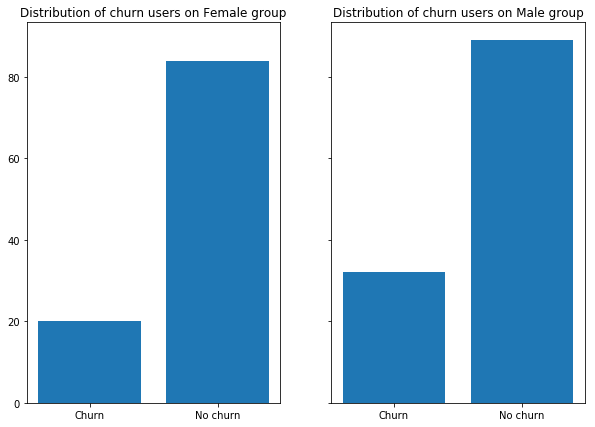

In [22]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7), sharey=True)
ax1.bar(['No churn', 'Churn'],df_sparkify_1[df_sparkify_1['gender']=='F'].groupby(['churn'])['userId'].count())
ax2.bar(['No churn', 'Churn'], df_sparkify_1[df_sparkify_1['gender']=='M'].groupby(['churn'])['userId'].count())
ax1.set_title('Distribution of churn users on Female group')
ax2.set_title('Distribution of churn users on Male group')
plt.show()

In [23]:
df_sparkify_1.groupby('churn')['region'].nunique()

churn
False    54
True     29
Name: region, dtype: int64

There are regions that does not have churn users. For this reason we have to be cautious including this feature into our ML model. If we have churn users in the full dataset, then it will be ok to add the feature in the model, if not, then we could overfit our model.



# 2 Churn by Songs and Days Registered


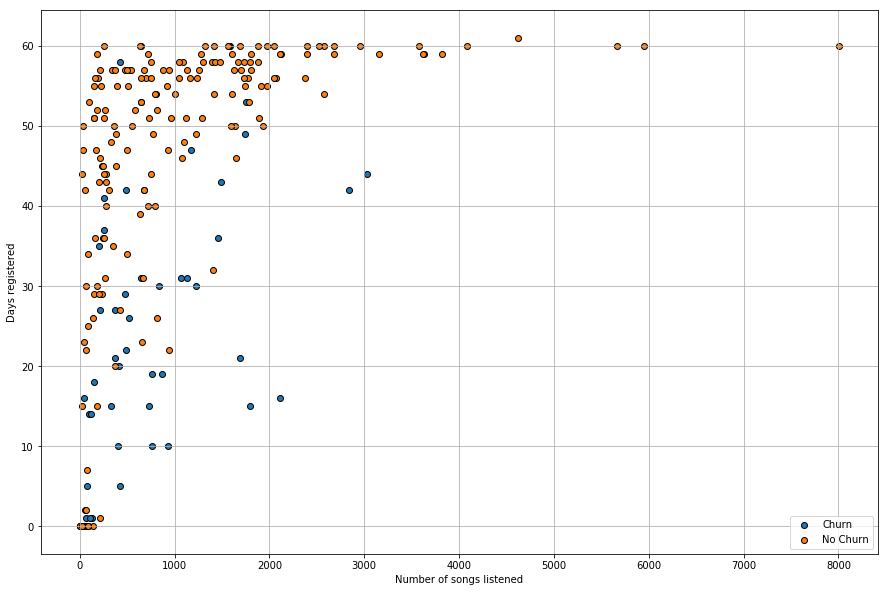

In [24]:
churn = df_sparkify_1[df_sparkify_1['churn']==True]
no_churn =df_sparkify_1[df_sparkify_1['churn']==False]

plt.figure(figsize=(15,10))
plt.scatter(churn['songsListened'], churn['totalDays'], edgecolor='black', label='Churn')
plt.scatter(no_churn['songsListened'], no_churn['totalDays'], edgecolor='black', label='No Churn')
plt.xlabel('Number of songs listened')
plt.ylabel('Days registered')
plt.grid()
plt.legend()
plt.show()

# 3 Churn by Total Sessions


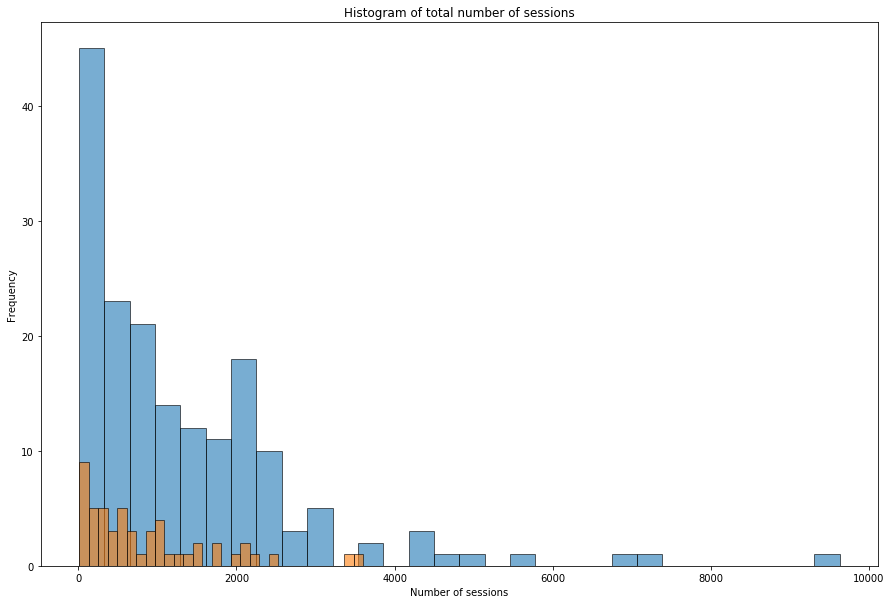

In [25]:

plt.figure(figsize=(15,10))
df_sparkify_1.groupby('churn')['totalSessions'].plot(kind='hist', alpha=0.6, edgecolor='black', bins=30, 
                                          title='Histogram of total number of sessions')
plt.xlabel('Number of sessions')
plt.show()
df_sparkify_1.plot

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# 1 Locate the Region  from the user location 

In [26]:
df_sparkify = df_sparkify.withColumn('region', F.split(df_sparkify.location, ', ')[1])


## 2. Get gender, region, first/last session, number of songs listened and number of total sessions by user¶


In [27]:
df_sparkify_agg = df_sparkify.groupBy('userId').agg(F.min('gender').alias('gender'),
                                                   F.min('region').alias('region'),
                                                   F.min('ts').alias('firstSession'), 
                                                   F.max('ts').alias('lastSession'),
                                                   F.count('song').alias('songsListened'),
                                                   F.count('sessionId').alias('totalSessions')).sort('userId')

df_sparkify_agg = df_sparkify_agg .withColumn("firstSession", \
                    F.to_timestamp(set_time(df_sparkify_agg.firstSession),'yyyy-MM-dd HH:mm:ss'))
df_sparkify_agg = df_sparkify_agg .withColumn("lastSession", \
                    F.to_timestamp(set_time(df_sparkify_agg.lastSession),'yyyy-MM-dd HH:mm:ss'))
df_sparkify_agg  = df_sparkify_agg .withColumn('totalDays', F.datediff("lastSession", "firstSession"))
df_sparkify_agg  = df_sparkify_agg.drop('firstSession').drop('lastSession')

## 3. Get the current suscription plan of each user¶


In [28]:
df_sparkify_level  = df_sparkify.groupby("userId", "level").agg(F.max(df_sparkify.time).alias("lastSession")).sort("userId")
df_sparkify_level_last  = df_sparkify_level.groupBy('userId').agg(F.max(df_sparkify_level.lastSession).alias('lastSession'))
df_sparkify_level_last = df_sparkify_level_last.join(df_sparkify_level, 
                  [df_sparkify_level.userId == df_sparkify_level_last.userId,
                  df_sparkify_level_last.lastSession == df_sparkify_level .lastSession]).select(
                  df_sparkify_level .userId, "level").sort("userId")

## 4. Compute the number of clicks to each page by user¶


In [29]:

df_sparkify_counts_long = df_sparkify.groupBy(['userId', 'page']).agg(F.count('page').alias('clicks'))
df_sparkify_counts_wide = df_sparkify_counts_long.groupBy('userId').pivot('page').agg(F.first('clicks')).sort('userId')
# Dropping Cancel and Cancelation Page as it is the page of churn
df_sparkify_counts_wide= df_sparkify_counts_wide.drop('Cancel') 
df_sparkify_counts_wide = df_sparkify_counts_wide.drop('Cancellation Confirmation') 
# Replacing nulls by 0 as they represent absence of clicks in that page
df_sparkify_counts = df_sparkify_counts_wide.na.fill(0)

## 5. Compute the average time session by user¶


In [30]:
session_time = df_sparkify.groupby("userId", "sessionId").agg(
    ((F.max(df_sparkify.ts) - F.min(df_sparkify.ts))/(1000*60)).alias("lengthSession"))
avg_session_time = session_time.groupby("userId").agg(
    F.avg(session_time.lengthSession).alias("avgSessionTime")).sort("userId")

## 6. Add label churn¶


In [31]:
df_sparkify_churn = df_sparkify.groupBy('userId').agg(F.min('churn').alias('churn')).sort('userId')

## 6. Merge all DataFrames and convert to numeric binary columns


In [32]:
df_sparkify_processed = df_sparkify_agg.join(df_sparkify_level_last, on='userId')
df_sparkify_processed = df_sparkify_processed.join(avg_session_time, on='userId')
df_sparkify_processed = df_sparkify_processed.join(df_sparkify_counts, on='userId')
df_sparkify_processed = df_sparkify_processed.join(df_sparkify_churn, on='userId')

df_sparkify_processed = df_sparkify_processed.replace(["M", "F"], ["0", "1"], "gender")
df_sparkify_processed = df_sparkify_processed.replace(["free", "paid"], ["0", "1"], "level")
df_sparkify_processed = df_sparkify_processed.replace(["false", "true"], ["0", "1"], "churn")
df_sparkify_processed = df_sparkify_processed.withColumn('gender', df_sparkify_processed.gender.cast("float"))
df_sparkify_processed = df_sparkify_processed.withColumn('level', df_sparkify_processed.level.cast("float"))

In [33]:
df_sparkify_processed.show(5)

+------+------+--------+-------------+-------------+---------+-----+------------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+
|userId|gender|  region|songsListened|totalSessions|totalDays|level|    avgSessionTime|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|churn|
+------+------+--------+-------------+-------------+---------+-----+------------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+
|100010|   1.0|      CT|          275|          381|       44|  0.0|154.48333333333332|    1|         4|              7|        0|    0|   2|  11|     5|     275|         52|            0|       0|     

In [34]:
df = df_sparkify_processed

In [35]:
file = "df.csv"
df.write.save(file, format="csv", header=True, mode='overwrite')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [36]:
df = spark.read.csv("df.csv", header=True)
df.persist()

DataFrame[userId: string, gender: string, region: string, songsListened: string, totalSessions: string, totalDays: string, level: string, avgSessionTime: string, About: string, Add Friend: string, Add to Playlist: string, Downgrade: string, Error: string, Help: string, Home: string, Logout: string, NextSong: string, Roll Advert: string, Save Settings: string, Settings: string, Submit Downgrade: string, Submit Upgrade: string, Thumbs Down: string, Thumbs Up: string, Upgrade: string, churn: string]

In [37]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- region: string (nullable = true)
 |-- songsListened: string (nullable = true)
 |-- totalSessions: string (nullable = true)
 |-- totalDays: string (nullable = true)
 |-- level: string (nullable = true)
 |-- avgSessionTime: string (nullable = true)
 |-- About: string (nullable = true)
 |-- Add Friend: string (nullable = true)
 |-- Add to Playlist: string (nullable = true)
 |-- Downgrade: string (nullable = true)
 |-- Error: string (nullable = true)
 |-- Help: string (nullable = true)
 |-- Home: string (nullable = true)
 |-- Logout: string (nullable = true)
 |-- NextSong: string (nullable = true)
 |-- Roll Advert: string (nullable = true)
 |-- Save Settings: string (nullable = true)
 |-- Settings: string (nullable = true)
 |-- Submit Downgrade: string (nullable = true)
 |-- Submit Upgrade: string (nullable = true)
 |-- Thumbs Down: string (nullable = true)
 |-- Thumbs Up: string (nullable = true)
 |-- Up

In [38]:
len(df.columns)

26

In [39]:
# When reading the csv all the columns converted to string, so we have to cast the numeric columns to float
df = df.replace(["false", "true"], ["0", "1"], "churn")
numeric_columns = ['gender', 'songsListened', 'totalSessions', 'totalDays', 'level', 'avgSessionTime', 'About',
 'Add Friend','Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 
 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up',
 'Upgrade', 'churn']

df = df.select('userId', 'region', 
                               *(F.col(column).cast("float").alias(column) for column in numeric_columns))

In [40]:
# This cell is not used as region can make overfit the model
# stringIndexer = StringIndexer(inputCol="region", outputCol="indexed")
# model = stringIndexer.fit(user_ml_df)
# user_ml_df = model.transform(user_ml_df)
# encoder = OneHotEncoder(inputCol="indexed", outputCol="regionEncoded")
# user_ml_df = encoder.transform(user_ml_df)
# user_ml_df = user_ml_df.drop('indexed')

In [41]:
df.show(1)

+------+------+------+-------------+-------------+---------+-----+--------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+
|userId|region|gender|songsListened|totalSessions|totalDays|level|avgSessionTime|About|Add Friend|Add to Playlist|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|churn|
+------+------+------+-------------+-------------+---------+-----+--------------+-----+----------+---------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+-----+
|100004|    NY|   1.0|        942.0|       1245.0|     57.0|  1.0|     185.98651|  0.0|      19.0|           23.0|     10.0|  2.0| 6.0|66.0|  19.0|   942.0|       86.0|          2.0|    11.0|             2.0|           3

In [42]:
columns = ['gender', 'songsListened', 'totalSessions', 'totalDays', 'level', 'avgSessionTime', 'About',
 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong',
 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down',
 'Thumbs Up', 'Upgrade']

In [43]:
assembler = VectorAssembler(inputCols=columns, outputCol="numColumns")
df = assembler.transform(df)

scaler = StandardScaler(inputCol="numColumns", outputCol="scaledColumns", withStd=True)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

In [44]:
df = df.select(df.scaledColumns.alias('features'), df.churn.alias('label'))

In [45]:
df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[2.00127105192366...|  0.0|
|[2.00127105192366...|  0.0|
|[0.0,1.4878356154...|  0.0|
|(23,[0,1,2,3,5,7,...|  0.0|
|(23,[1,2,3,5,11,1...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [46]:
train, test = df.randomSplit([0.8, 0.2], seed=42)
train = train.cache()

In [47]:
lr =  LogisticRegression()

paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0,1]) \
    .addGrid(lr.regParam, [0, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
lr_model = crossval.fit(train)
results_lr_train = lr_model.transform(train)
results_lr_test = lr_model.transform(test)

In [48]:
lr_model.save('Model_lr.model')

In [49]:
rcf = RandomForestClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(rcf.numTrees, [50, 100]) \
    .addGrid(rcf.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=rcf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
rcf_model = crossval.fit(train)
results_rcf_train = rcf_model.transform(train)
results_rcf_test = rcf_model.transform(test)


In [50]:
rcf_model.save('Model_rcf.model')


In [51]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)
gbt_model = crossval.fit(train)
results_gbt_train = gbt_model.transform(train)
results_gbt_test = gbt_model.transform(test)

In [52]:
gbt_model.save('Model_gbt.model')

In [53]:
def calculate_f1(results):
    """Given a table of pyspark.ml.model.transform results, the function calculates and returns the F1 score."""
    true_positives = results.filter("label = 1 and prediction = 1").count()
    false_positives = results.filter("label = 0 and prediction = 1").count()
    false_negatives = results.filter("label = 1 and prediction = 0").count()
    precision = true_positives / (true_positives + false_positives) 
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * precision * recall / (precision + recall)
    
    return f1

In [54]:
results_df = pd.DataFrame({'score': [calculate_f1(results_lr_train), calculate_f1(results_rcf_train),
                                      calculate_f1(results_gbt_train), calculate_f1(results_lr_test),
                                      calculate_f1(results_rcf_test), calculate_f1(results_gbt_test)],
                           'dataset': ['Train', 'Train', 'Train', 'Test', 'Test', 'Test'],
                           'model': ['LogisticRegression', 'RandomForest', 'GradientBoosting',
                                     'LogisticRegression', 'RandomForest', 'GradientBoosting']})

In [55]:
print('F1 score in Logistic Regression model in trainset: ',  calculate_f1(results_lr_train))
print('F1 score in Logistic Regression model in testset: ', calculate_f1(results_lr_test))
print('F1 score in Random Forest model in trainset: ', calculate_f1(results_rcf_train))
print('F1 score in Random Forest model in testset: ', calculate_f1(results_rcf_test))
print('F1 score in Gradient Boosting model in trainset: ', calculate_f1(results_gbt_train))
print('F1 score in Gradient Boosting model in testset: ', calculate_f1(results_gbt_test))

F1 score in Logistic Regression model in trainset:  0.3548387096774194
F1 score in Logistic Regression model in testset:  0.39999999999999997
F1 score in Random Forest model in trainset:  0.9
F1 score in Random Forest model in testset:  0.47058823529411764
F1 score in Gradient Boosting model in trainset:  1.0
F1 score in Gradient Boosting model in testset:  0.4444444444444445


From the metrics calculated above, logistic regression, amongst the other two classifiers, performs the best in average in predicting the churn rate for Sparkify with the calculated F1 score of 44.4% 

## Tune GBT classfier to optimize performance

In [56]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, np.arange(10, 20, 30)) \
    .addGrid(gbt.maxDepth, np.arange(3, 7, 1)) \
    .addGrid(gbt.minInstancesPerNode, [1, 10, 20]) \
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)
gbt_model_refined = crossval.fit(train)
results_gbt = gbt_model_refined.transform(test)
results_gbt_tr = gbt_model_refined.transform(train)

In [57]:
gbt_model_refined.save('Model_gbt_refined.model')

In [58]:
print('F1 score in Gradient Boosting model in trainset: ', calculate_f1(results_gbt_tr))
print('F1 score in Gradient Boosting model in testset: ', calculate_f1(results_gbt))

F1 score in Gradient Boosting model in trainset:  0.8131868131868133
F1 score in Gradient Boosting model in testset:  0.5833333333333334


As seen from the classification and analysis done above, we can first see that GBT clasifer performed the best compared to random forest and logical regresion  classifiers as measured with its highest F1 score. However, in order to optimize its F1 score and performance, I tuned the hyperparameters of the logistic regression,  As a result, the tuned gbt classfier scored an improved F1 score of 54.4% against the original F1 score of 44.4%, 

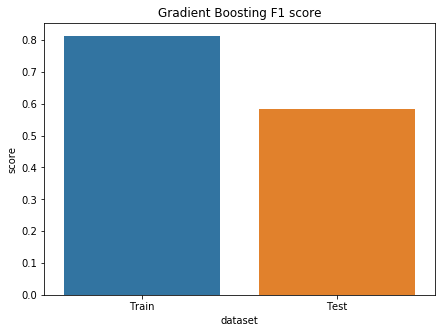

In [59]:
results_df = pd.DataFrame({'score': [calculate_f1(results_gbt_tr), calculate_f1(results_gbt)],
                           'dataset': ['Train', 'Test']})
plt.figure(figsize=(7,5))
sns.barplot(x='dataset', y='score', data=results_df)
plt.title('Gradient Boosting F1 score')
plt.show()

In [60]:
gbt_model.avgMetrics


[0.8178242744909412,
 0.6940684624017958,
 0.8210838544171878,
 0.6881016514349847]

In [61]:
gbt_model.bestModel.featureImportances

SparseVector(23, {0: 0.0385, 1: 0.0711, 2: 0.0319, 3: 0.372, 5: 0.0171, 6: 0.025, 7: 0.0338, 8: 0.0472, 9: 0.0054, 10: 0.0, 11: 0.0086, 12: 0.0186, 13: 0.0058, 15: 0.0417, 16: 0.0004, 17: 0.0631, 19: 0.0331, 20: 0.165, 21: 0.0193, 22: 0.0025})

# Final Steps

Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

Done 